# Оценка возможности прогнозирования ДТП

Задача -  понять, возможно ли предсказывать риск ДТП по выбранному маршруту движения, опираясь на исторические данные.Под риском понимается вероятность ДТП с любым повреждением транспортного средства.

В ходе исследование необходимо выяснить, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:

- Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
- Какие ещё факторы нужно учесть?
- Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

## Подключение к базе и загрузка таблиц sql

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics

from sqlalchemy import create_engine
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 


connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [3]:
engine = create_engine(connection_string) 

## Первичное исследование таблиц

### Таблица case_ids

In [4]:
query = '''

SELECT *
FROM case_ids
LIMIT 5

'''

case_id_df = pd.read_sql_query(query, con=engine) 
case_id_df#.head()

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Таблица содержит уникальный case_id, второй столбец отличается от представленного в документации и скорее всего обозначает год создания базы данных.

### Таблица vehicles

In [5]:
query = '''

SELECT *
FROM vehicles
LIMIT 5

'''

vehicles_df = pd.read_sql_query(query, con=engine) 
vehicles_df

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Таблица содержит данные об автомобилях, участвовавших в ДТП.

### Таблица parties

In [6]:
query = '''

SELECT *
FROM parties
LIMIT 5

'''

parties_df = pd.read_sql_query(query, con=engine) 
parties_df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Таблица содержит описание участников происшествия, названия столбцов соотвествуют описанию, но столбцы содержат полное название вместо буквенного сокращения как указано в описании к данным.

### Таблица collisions

In [7]:
query = '''

SELECT *
FROM collisions
LIMIT 5
'''

collisions_df = pd.read_sql_query(query, con=engine) 
collisions_df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Таблица содержит информацию о происшествия, содержимое столбцов также не использует буквенные сокращения.

Имеется общий ключ для связи таблиц - поле case_id.

##  Cтатистический анализ факторов ДТП

### Выявление наиболее аварийных месяцев

Выясним, в какие месяцы происходит наибольшее количество аварий. Для этого выгрузим нужные столбцы из таблицы collisions, посчитаем количество case_id и сгруппируем по месяцам.

In [8]:
query = '''

SELECT DISTINCT extract(MONTH FROM cast(collision_date AS date))::int AS collision_month,
                count(case_id) AS case_count
FROM collisions
GROUP BY 1
'''
coll_count_df = pd.read_sql_query(query, con=engine) 
coll_count_df

,collision_month,case_count
0,1,132044
1,2,128858
2,3,139581
3,4,130180
4,5,130316
5,6,102594
6,7,102227
7,8,104089
8,9,105159
9,10,112237


Построим график по полученной таблице:

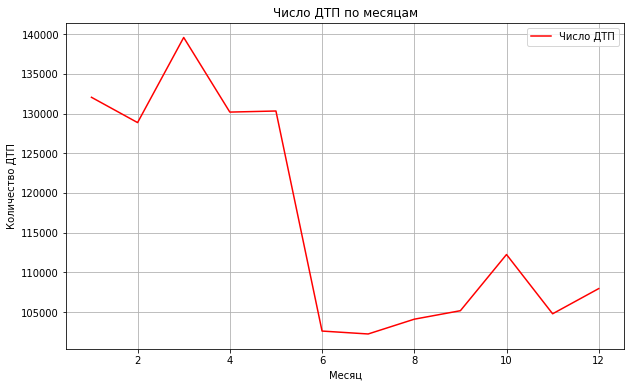

In [9]:
plt.figure(figsize=[10,6])
sns.lineplot(data=coll_count_df, x='collision_month', y='case_count', label='Число ДТП', color='red')
plt.legend()
plt.title('Число ДТП по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.grid()
plt.show()

Наибольшее количество ДТП наблюдается в период с января по май, дальше идет резкое снижение, пик приходится на март. Такой всплеск можно обьяснить неблагоприятными погодными условиями и состоянием дорог в зимне-весенний период, либо же неполнотой данных за период с июня по декабрь.

In [10]:
query = '''

SELECT DISTINCT date_trunc('month', collision_date)::date AS collision_month,
                count(case_id) AS case_count
FROM collisions
GROUP BY 1
HAVING count(case_id) < 30000
ORDER by 2 

'''
missing_count_df = pd.read_sql_query(query, con=engine) 
missing_count_df

,collision_month,case_count
0,2013-06-01,1
1,2013-07-01,1
2,2020-03-01,1
3,2020-07-01,1
4,2013-04-01,5
5,2013-03-01,46
6,2013-02-01,108
7,2013-01-01,144
8,2012-12-01,200
9,2012-11-01,253


Данные действительно неполные, преимущественно по летним месяцам для разных годов, тк мы считали количество аварий за все время наблюдения, появился провал на графике.

### Постановка задач для рабочей группы

1. Найти ДТП с числом участников больше 4, в которых водитель разговаривал по телефону.
 - Объединить таблицы collisions и parties;
 - Вывести на столбчатой диаграмме число происшествий с использованием телефона и без него.

2. Выяснить, в какие месяцы за все время наблюдений чаще всего наблюдаются неблагоприятное состояние дороги по естественным причинам - мокрая либо заснеженная.
   
3. Выявить пять округов, в которых наиболее часто виновниками аварии являются пьяные водители в ночное время (с 23:00 до 05:00), а также средний возраст автомобилей по этим округам
 - Объединить таблицы vehicles, collisions и parties
 - Вывести название округа, число виновников ДТП по убыванию, и средний возраст автомобиля для каждого региона.

4. Вывести число уникальных id происшествий с участием минивэнов по месяцам.

5. Выяснить, на сколько процентов менялось количество ДТП с участием велосипедистов ежемесячно с 1 марта по 31 октября 2011
года, вывести номер месяца, количество происшествий и процент.

6. Выяснить, автомобиль с каким типом кузова чаще всего становится виновником аварии.



#### Задача 1

Выясним, в какие месяцы за все время наблюдений чаще всего наблюдаются неблагоприятное состояние дороги по естественным причинам - мокрая либо заснеженная.

In [11]:
query = '''

SELECT DISTINCT extract(MONTH FROM cast(collision_date AS date))::int AS collision_month,
                count(road_surface) AS bad_surface_count
FROM collisions
WHERE road_surface = 'wet'
  OR road_surface = 'snowy'
GROUP BY 1
ORDER BY 2 DESC

'''
bad_surface_df = pd.read_sql_query(query, con=engine) 
bad_surface_df

,collision_month,bad_surface_count
0,2,28077
1,12,24981
2,1,22398
3,3,20212
4,10,13374
5,11,11558
6,4,10704
7,5,6794
8,6,2790
9,9,1353


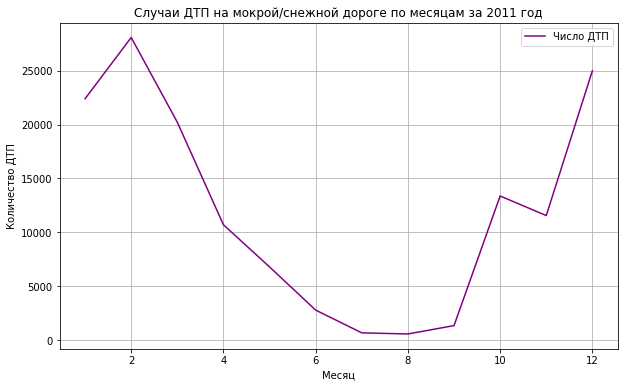

In [12]:
plt.figure(figsize=[10,6])
sns.lineplot(data=bad_surface_df, x='collision_month', y='bad_surface_count', label='Число ДТП', color='purple')

plt.legend()
plt.title('Случаи ДТП на мокрой/снежной дороге по месяцам за 2011 год')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.grid()
plt.show()

Чаще всего неблагоприятные погодные условия наблюдаются с октября по март, пиковый месяц - февраль.

#### Задача 2

Выявить пять округов, в которых наиболее часто виновниками аварии являются пьяные водители в ночное время (с 23:00 до 05:00), а также средний возраст автомобилей по этим округам.

In [13]:
query = '''

SELECT county_location,
       count(c.case_id) AS case_count,
       round(avg(v.vehicle_age), 1) AS avg_vehicle_age
FROM parties p
JOIN collisions c ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id
WHERE at_fault = 1
  AND party_sobriety like '%%had been%%'
  AND (extract(HOUR FROM cast(collision_time AS TIME))::int <= 5
       OR extract(HOUR FROM cast(collision_time AS TIME))::int >= 23)
GROUP BY county_location
ORDER BY 2 DESC
LIMIT 5

'''
drunk_df = pd.read_sql_query(query, con=engine) 
drunk_df

,county_location,case_count,avg_vehicle_age
0,los angeles,10909,4.3
1,san diego,3116,4.2
2,orange,3084,4.1
3,san bernardino,1991,4.2
4,riverside,1973,4.2


Лос-Анджелес занимает первое место, но учитывая население 10 млн, и к примеру население округа Сан-Диего в 3 млн, пропорции практически одинаковы.

## Создание модели для оценки водительского риска

### Выявление признаков и выгрузка данных

Прежде чем создать модель, выявим факторы, влияющие на целевой признак at_fault.

Таблица vehicles:

 - `vehicle_transmission` -  авто с МКПП может быть сложнее для  неопытных водителей, использующих каршеринг.
 
Таблица parties:
 - `at_fault` - целевой признак;
 - `cellphone_in_use` - использование телефона снижает внимательность;
 - `party_sobriety` - трезвость водителя;
 
Таблица collisions:

 - `weather_1` - погода;
 - `intersection` - чаще всего, по статистике, ДТП происходят именно на перекрестках;
 - `pcf_violation_category`- основная причина аварии, выявление причины позволит предотвращать аварии в будущем;
 - `motor_vehicle_involved_with` - дополнительные участники ДТП, выявление наиболее частых участников позволит уменьшить число дтп;
 - `road_surface` - состояние поверхности дороги - гололед, мокрая/скользкая/сухая дорога;
 - `control_device` - наличие контролирующего утройства - неизвестный фактор, который модет оказать влияние
 - `lighting` - освещенность дороги.
 
 
С помощью запроса выгрузим необходимые данные в таблицу. По условию задачи, нужны только данные за 2012 год, где участник аварии - машина и с повреждениями больше чем царапина. 
 

In [14]:
query = '''

SELECT DISTINCT c.case_id,
       weather_1,
       pcf_violation_category,
       motor_vehicle_involved_with,
       road_surface,
       control_device,
       lighting,
       vehicle_transmission,
       cellphone_in_use, 
       party_sobriety,
       at_fault
FROM collisions c
inner JOIN parties p ON c.case_id = p.case_id inner JOIN vehicles v ON c.case_id = v.case_id 
WHERE (extract(YEAR FROM cast(collision_date AS date))::int = 2012
  AND party_type = 'car'
  AND collision_damage != 'scratch')


'''
df = pd.read_sql_query(query, con=engine) 

df.head()

,case_id,weather_1,pcf_violation_category,motor_vehicle_involved_with,road_surface,control_device,lighting,vehicle_transmission,cellphone_in_use,party_sobriety,at_fault
0,5125160,cloudy,automobile right of way,other motor vehicle,dry,none,daylight,auto,0.0,had not been drinking,0
1,5125160,cloudy,automobile right of way,other motor vehicle,dry,none,daylight,auto,0.0,had not been drinking,1
2,5173738,clear,speeding,other motor vehicle,dry,none,daylight,auto,0.0,had not been drinking,0
3,5173738,clear,speeding,other motor vehicle,dry,none,daylight,auto,0.0,had not been drinking,1
4,5269486,clear,unknown,other motor vehicle,dry,functioning,daylight,auto,0.0,had not been drinking,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91894 entries, 0 to 91893
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      91894 non-null  object 
 1   weather_1                    91628 non-null  object 
 2   pcf_violation_category       90577 non-null  object 
 3   motor_vehicle_involved_with  91642 non-null  object 
 4   road_surface                 91347 non-null  object 
 5   control_device               91534 non-null  object 
 6   lighting                     91642 non-null  object 
 7   vehicle_transmission         90327 non-null  object 
 8   cellphone_in_use             82795 non-null  float64
 9   party_sobriety               90461 non-null  object 
 10  at_fault                     91894 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 7.7+ MB


In [16]:
df.isna().sum()/len(df)

case_id                        0.000000
weather_1                      0.002895
pcf_violation_category         0.014332
motor_vehicle_involved_with    0.002742
road_surface                   0.005953
control_device                 0.003918
lighting                       0.002742
vehicle_transmission           0.017052
cellphone_in_use               0.099016
party_sobriety                 0.015594
at_fault                       0.000000
dtype: float64

Доля пропущенных значений < 10%, можем их удалить.

In [17]:
df = df.dropna() 

Проверим на наличие полных дубликатов:

In [18]:
df.duplicated().sum()

0

Дубликаты отсутствуют, теперь можем удалить столбец с id:

In [19]:
df = df.drop('case_id', axis=1) 

Посмотрим на значения в датафрейме:

In [20]:
df['lighting'].unique() 

array(['daylight', 'dark with street lights', 'dusk or dawn',
       'dark with no street lights',
       'dark with street lights not functioning'], dtype=object)

Избавимся от пробелов в названиях и от слишком большого кол-ва категорий - присвоим значение dark всем категориям, обозначающим неосвещенную улицу.

In [21]:
def fix_value(cell):
     cell = cell.replace(' ', '_')  # функция, заменяющая все пробелы на подчеркивания
     return cell 

In [22]:
df['lighting'] = df['lighting'].apply(lambda x: 'dark' if 'dark' in x else x)
df['lighting'] = df['lighting'].apply(fix_value)

То же самое сделаем с признаком party_sobriety, оставив только факт, был участник в состоянии опьянения или нет:

In [23]:
df['party_sobriety'].unique() 

array(['had not been drinking', 'had been drinking, under influence',
       'had been drinking, impairment unknown',
       'had been drinking, not under influence', 'impairment unknown',
       'not applicable'], dtype=object)

In [24]:
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'sober' if 'had not' in x else x)
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'drunk' if 'had been' in x else x)
df['party_sobriety'] = df['party_sobriety'].apply(lambda x: 'drunk' if 'impairment' in x else x)

df['party_sobriety'] = df['party_sobriety'].apply(fix_value)

Далее рассмотрим категории нарушений. Здесь можно обьединить нарушения правил пешеходами в одну группу, тк задача - рассмотреть причины только автомобильных аварий. Также можно объединить в одну категорию технические неисправности.

In [25]:
df['pcf_violation_category'].unique() 

array(['automobile right of way', 'speeding', 'unknown',
       'improper turning', 'other hazardous violation',
       'pedestrian violation', 'dui', 'pedestrian right of way',
       'traffic signals and signs', 'other than driver (or pedestrian)',
       'wrong side of road', 'improper passing', 'other improper driving',
       'unsafe lane change', 'hazardous parking', 'following too closely',
       'unsafe starting or backing', 'lights', 'impeding traffic',
       'other equipment', 'brakes', 'fell asleep'], dtype=object)

In [26]:
df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: 'equipment_fault' if x == 'brakes' 
                                                                  or x == 'other equipment'
                                                                  or x == 'lights' else x)
df['pcf_violation_category'] = df['pcf_violation_category'].apply(lambda x: 'pedestrian_involved' if x == 'automobile right of way' 
                                                                  or x == 'pedestrian violation' 
                                                                  or x == 'dui' 
                                                                  or x == 'other than driver (or pedestrian)'  
                                                                  or x == 'improper passing' else x)

df['pcf_violation_category'] = df['pcf_violation_category'].apply(fix_value)

In [27]:
df['motor_vehicle_involved_with'].unique() 

array(['other motor vehicle', 'other object', 'fixed object',
       'non-collision', 'bicycle', 'parked motor vehicle', 'train',
       'animal', 'motor vehicle on other roadway'], dtype=object)

In [28]:
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(lambda x: 'other_vehicle' if x == 'other motor vehicle' 
                                                                  or x == 'motor vehicle on other roadway' else x)

df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(lambda x: 'fixed object' if x == 'parked motor vehicle' else x)
df['motor_vehicle_involved_with'] = df['motor_vehicle_involved_with'].apply(fix_value)

### Aнализ важности факторов ДТП

Проведем простое кодирование категориальных признаков для оценки зависимостей:

In [29]:
categorial = ['weather_1', 
              'pcf_violation_category',
              'motor_vehicle_involved_with', 
              'road_surface',
              'control_device', 
              'lighting', 
              'vehicle_transmission', 
              'party_sobriety' ]

In [30]:
df_tmp = pd.get_dummies(df, columns=categorial, drop_first=True)

In [31]:
numeric =['cellphone_in_use']

scaler = StandardScaler()
scaler.fit(df_tmp[numeric])
df_tmp[numeric] = scaler.transform(df_tmp[numeric])

pd.options.mode.chained_assignment = None

Посмотрим на корелляцию признаков:

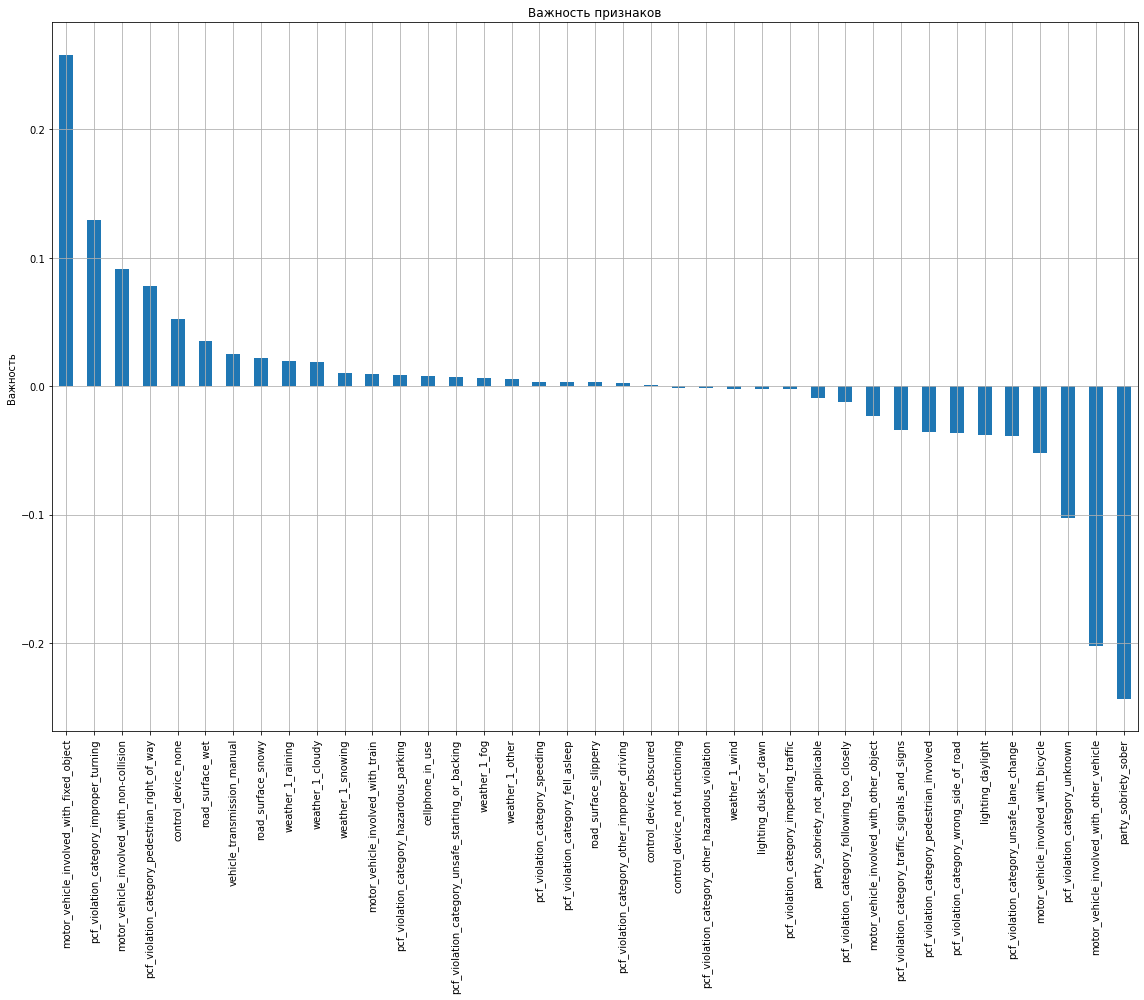

In [32]:
fig, ax = plt.subplots(figsize=(16,14))
df_tmp.corr().iloc[1].sort_values(ascending=False).drop('at_fault',axis = 0).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
plt.grid()

fig.tight_layout()

Из графика видим, что прямое влияние на виновность в ДТП оказывает:
 - Участие пьяных водителей
 - Столкновения с неподвижными объектами
 - Нарушения ПДД
 - Мокрая дорога
 - Автомобили с МКПП
 - Использование телефона
 
Обратная зависимость:
 - Трезвый водитель
 - При дневном свете
 - По вине пешеходов
 
 

### Разделение на выборки и кодирование признаков

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('at_fault', axis=1), 
                                                    df['at_fault'], 
                                                    train_size=0.8, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                   stratify=df['at_fault']) # сохраняем баланс классов

In [34]:
tmp_train = X_train[categorial]
tmp_test= X_test[categorial]


encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(X_train[categorial])

tmp_train = pd.DataFrame(encoder_ohe.transform(X_train[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=X_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(X_test[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=X_test.index)

X_train.drop(categorial, axis=1, inplace=True)
X_train = X_train.join(tmp_train)

X_test.drop(categorial, axis=1, inplace=True)
X_test = X_test.join(tmp_test)

Посмотрим на баланс классов:

1    0.532265
0    0.467735
Name: at_fault, dtype: float64


<AxesSubplot:>

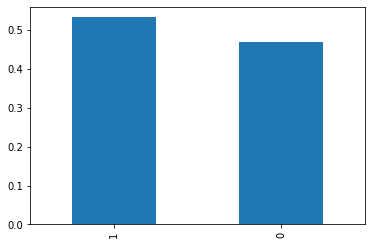

In [35]:
class_frequency = y_train.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

In [36]:
class_frequency[0]/class_frequency[1]

0.8787625916433213

Классы можно считать сбалансированными, распределние близко к 50%.

При сравнении моделей в качестве определяющей метрики будем использовать точность (*precision*), тк она показывает долю истинно положительных ответов.

Для вычисления метрик и построения графика определим функцию metrics_func:

In [37]:
def metrics_func(model):
    model.fit(X_train, y_train)
    predicted_test = model.predict(X_test)
    probabilities_test = model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]
    precision = precision_score(y_test, predicted_test)
    recall = recall_score(y_test, predicted_test)
    print('Точность:', precision)
    print('Полнота:', recall)
    print('Доля правильных ответов:', accuracy_score(y_test, predicted_test)) 
    print('F1-мера:', f1_score(y_test, predicted_test))
    print('AUC-ROC:', roc_auc_score(y_test, probabilities_one_test), '\n')
    print('Матрица ошибок:')
    print(confusion_matrix(y_test, predicted_test))

# строим ROC-кривую
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

    plt.figure()

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    
    plt.show()
    return precision, predicted_test, probabilities_one_test, model

### Модель решающего дерева

In [38]:
params =  {'max_depth': range (1,15, 2),
           'min_samples_leaf': range (1,12),
           'min_samples_split': range (2,14,2)}
           
model = DecisionTreeClassifier()

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=12345
)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 9}


Точность: 0.8898379970544918
Полнота: 0.3601144355703898
Доля правильных ответов: 0.6356598984771573
F1-мера: 0.5127291242362526
AUC-ROC: 0.6991621972549377 

Матрица ошибок:
[[6997  374]
 [5368 3021]]


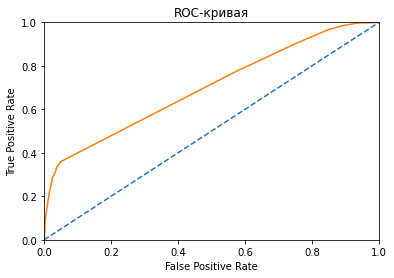

In [39]:
precision_dt, predictions_dt, probabilities_dt, model_dt  = metrics_func(DecisionTreeClassifier(max_depth=9, 
                                                                                             min_samples_split=10, 
                                                                                             min_samples_leaf=4, 
                                                                                             random_state=12345,
                                                                                             class_weight='balanced'))

### Модель случайного леса

In [40]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'min_samples_leaf': range (1,8),
           'min_samples_split': range (2,10,2)}
           
model = RandomForestClassifier()

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=12345
)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'n_estimators': 115, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 13}


In [ ]:
precision_rf, predictions_rf, probabilities_rf, model_rf = metrics_func(RandomForestClassifier(n_estimators=145, 
                                                                                 max_depth=13, 
                                                                                 min_samples_split=8, 
                                                                                 min_samples_leaf=5, 
                                                                                 random_state=12345,
                                                                                 class_weight='balanced'))

### LightGBM

In [42]:
params =  {'n_estimators': range(10, 155, 15),
           'max_depth': range (1,15),
           'num_leaves': range (2,50, 10)}
           
model = LGBMClassifier()

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=12345
)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'num_leaves': 42, 'n_estimators': 10, 'max_depth': 9}


Точность: 0.8910425844346549
Полнота: 0.3616640839194183
Доля правильных ответов: 0.6366751269035533
F1-мера: 0.5144988977446159
AUC-ROC: 0.7064271472425007 

Матрица ошибок:
[[7000  371]
 [5355 3034]]


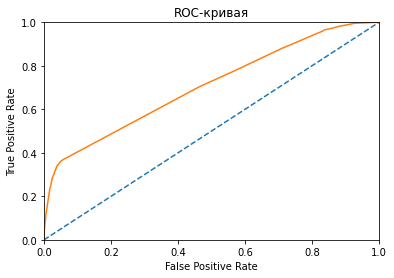

In [43]:
precision_lgbm, predictions_lgbm, probabilities_lgbm, model_lgbm = metrics_func(LGBMClassifier(boosting_type='gbdt',
                                                                                            random_state=12345, 
                                                                                            max_depth=9,
                                                                                            n_estimators=10,
                                                                                            learning_rate = 0.1,
                                                                                            num_leaves = 42,
                                                                                            class_weight='balanced'))

### Catboost

In [44]:
params =  {'iterations': range(100, 2600, 500),
           'depth': range (1,15)}
           
model = CatBoostClassifier(verbose=False)

grid = RandomizedSearchCV(model,
    param_distributions=params, 
    scoring='precision', 
    n_jobs=-1, 
    random_state=12345
)

grid.fit(X_train, y_train)

print(grid.best_params_)

{'iterations': 1100, 'depth': 5}


Точность: 0.8564102564102564
Полнота: 0.3782334008821075
Доля правильных ответов: 0.6352791878172589
F1-мера: 0.5247230031420539
AUC-ROC: 0.7047501040626959 

Матрица ошибок:
[[6839  532]
 [5216 3173]]


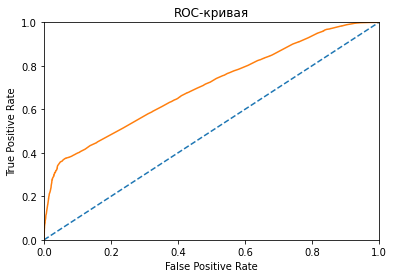

In [45]:
precision_cb, predictions_cb, probabilities_cb, model_cb = metrics_func(CatBoostClassifier(depth=5,
                                                                                        iterations=1100,
                                                                                        random_seed=60,
                                                                                        learning_rate=0.003, 
                                                                                        verbose=False))

Проверим адекватность моделей на пустышке:

Точность: 0.5322969543147208
Полнота: 1.0
Доля правильных ответов: 0.5322969543147208
F1-мера: 0.694769969771005
AUC-ROC: 0.5 

Матрица ошибок:
[[   0 7371]
 [   0 8389]]


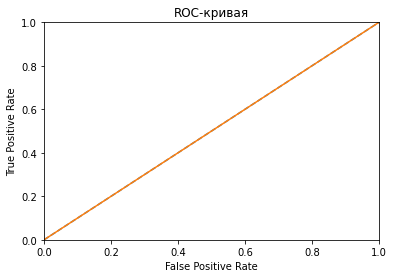

In [46]:
precision_dumm, predictions_dumm, probabilities_dumm, model_dumm  = metrics_func(DummyClassifier(strategy='most_frequent'))

Все модели имеют примерно схожие показатели. 

Оформим результат в виде таблицы:

In [52]:
result = pd.DataFrame ([
    [precision_dt],
    [precision_rf],
    [precision_lgbm],
    [precision_cb],
    [precision_dumm]], 
    columns=['precision'],
    index=['DecisionTree','RandomForest', 'LightGBM', 'CatBoost', 'Dummy'])
result.sort_values(by='precision', ascending=False)

,precision
LightGBM,0.891043
DecisionTree,0.889838
RandomForest,0.864491
CatBoost,0.856410
Dummy,0.532297


Наибольшее значение точности имеет модель LightGBM - 0.891043.

## Анализ лучшей модели

Матрица ошибок для модели LightGBM:

In [48]:
confusion_matrix(y_test, predictions_lgbm)

array([[7000,  371],
       [5355, 3034]], dtype=int64)

Здесь, как и на матрицах для остальных моделей, мы видим высокое число ложно-положительных ответов, и при этом малое число ложно-отрицательных -  лучше ошибочно прездсказать аварийную ситуацию, чем ошибочно не предсказать.

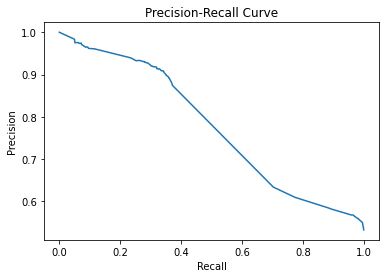

In [49]:
precision, recall, thresholds = precision_recall_curve(y_test, probabilities_lgbm)

fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

Проанализируем важность основных факторов, влияющих на вероятность ДТП:

In [50]:
smf = SelectFromModel(model_lgbm, threshold=-np.inf, max_features = 25)
smf.fit(X_train, y_train)
features_index = smf.get_support()
features_1 = X_train.columns[features_index]
features_1

Index(['weather_1_cloudy', 'pcf_violation_category_equipment_fault',
       'pcf_violation_category_following_too_closely',
       'pcf_violation_category_improper_turning',
       'pcf_violation_category_other_hazardous_violation',
       'pcf_violation_category_pedestrian_involved',
       'pcf_violation_category_pedestrian_right_of_way',
       'pcf_violation_category_speeding',
       'pcf_violation_category_traffic_signals_and_signs',
       'pcf_violation_category_unknown',
       'pcf_violation_category_unsafe_lane_change',
       'pcf_violation_category_wrong_side_of_road',
       'motor_vehicle_involved_with_animal',
       'motor_vehicle_involved_with_bicycle',
       'motor_vehicle_involved_with_fixed_object',
       'motor_vehicle_involved_with_non-collision',
       'motor_vehicle_involved_with_other_object',
       'motor_vehicle_involved_with_other_vehicle', 'road_surface_dry',
       'control_device_functioning', 'control_device_none', 'lighting_dark',
       'lighting_

Можно выявить наиболее важные факторы, влияющие на вероятность ДТП:
 - Факт алкогольного опьянения
 - Столкновение с объектом
 - Освещенность улицы
 - Наезд на пешехода, когда пешеход имел приемущество
 - Мокрая дорога
 
 
Рассмотрим один из факторов, и построим график зависимости фактора и целевой переменной:

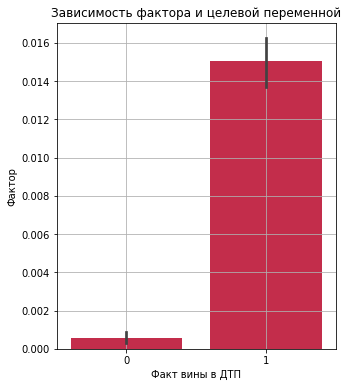

In [53]:
plt.figure(figsize=[5,6])
sns.barplot(x=y_train, y=X_train['pcf_violation_category_pedestrian_right_of_way'], color='crimson')
plt.title('Зависимость фактора и целевой переменной')
plt.xlabel('Факт вины в ДТП')
plt.ylabel('Фактор')
plt.grid()
plt.show()

Здесь мы взяли признак `pedestrian_right_of_way`, что можно истолковать как ДТП, где преимущество было у пешехода. Чтобы предотвратить подобные случаи, автомобили предпочтительно оборудовать системой экстренного торможения, напрмер подобной Volvo City Safety. 

Также для повышения безопасности рекомендуется оборудование автомобилей встроенным навигатором, предупреждающем об ограничениях скорости и автоматической коробкой передач.

## Выводы

Создание системы оценки водительского риска вероятно, однако стоит учитывать не только внешние факторы, такие как состояние дорожного покрытия или освещенность улицы, но некоторые данные касающиеся самого водителя, такие как стаж, участие в дтп в качестве виновника ранее и тд. Также стоит в будущем учитывать плотность движения.
Для повышения безопасности рекомендуется оборудовать автомобили системой экстренного торможения. 